In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import geopandas as gpd
import wbgapi as wb
import math
import dill
import pathlib
from autumn.settings import INPUT_DATA_PATH

In [89]:
dill.load_session('kir.db')

In [2]:
kir_tb = wb.data.DataFrame(['SH.TBS.CURE.ZS', 'SH.TBS.DTEC.ZS', 'SH.TBS.INCD'], 'KIR', mrv = 20)

In [3]:
series_name = {'SH.TBS.CURE.ZS':'Tuberculosis treatment success rate (% of new cases)',
                'SH.TBS.DTEC.ZS': 'Tuberculosis case detection rate (%, all forms)',
                'SH.TBS.INCD': 'Incidence of tuberculosis (per 100,000 people)'
            }

In [4]:
kir_tb.reset_index(inplace=True)
kir_tb.replace({'series':series_name}, inplace = True)
df = pd.melt(kir_tb, id_vars='series')
df.rename(columns={'variable':'Year'}, inplace = True)
df['Year'] = df['Year'].str[2:].astype(int)
df.reset_index(drop = True, inplace=True)
p = pathlib.PurePath(INPUT_DATA_PATH, 'tb_kir', "bcg.csv")
bcg = pd.melt(pd.read_csv(p), id_vars="Year")
bcg.rename(columns={'variable':'series'}, inplace = True)
newdf = pd.concat([df, bcg], ignore_index=True)
newdf.index = pd.to_datetime(newdf['Year'], format = "%Y")
df = newdf
del newdf
del bcg

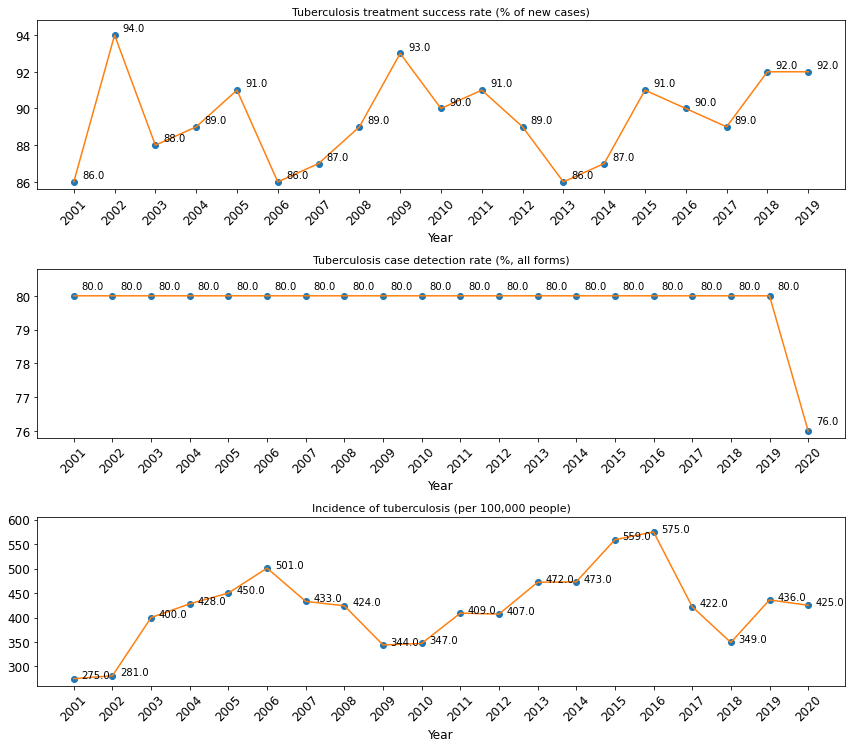

In [8]:
indi = df['series'].unique().tolist()
fig, ax = plt.subplots(nrows=len(indi), figsize=(12,len(indi)*3.5))
loc = plticker.MultipleLocator(base=1)
for i in indi:
    idx = indi.index(i)
    filt = df['series'] == i
    ax[idx].plot(df.loc[filt]['Year'],df.loc[filt]['value'], 'o')
    ax[idx].plot(df.loc[filt]['Year'],df.loc[filt]['value'])
    ax[idx].set_title(i, size=11) #here I am setting the title of each subplot to be the category
    ax[idx].set_xlabel('Year', size=12) #setting the ylabel and font size
    
    for j, val in enumerate(df.loc[filt]['value'].to_list()):
        if not math.isnan(val):
            ax[idx].text(df.loc[filt]['Year'].to_list()[j]  + .2, df.loc[filt]['value'].to_list()[j] + .2, str(val))
    if i == series_name['SH.TBS.INCD']:
        ax[idx].set_ylim(top = max(df.loc[filt]['value']) + 30)
    else:
        ax[idx].set_ylim(top = max(df.loc[filt]['value']) + 0.8)
    ax[idx].xaxis.set_major_locator(loc)
    ax[idx].xaxis.set_tick_params(labelsize=12, labelrotation = 45) #setting the font size of the x axis
    ax[idx].yaxis.set_tick_params(labelsize=12)
plt.tight_layout()

In [ ]:
dill.dump_session('kir.db')